In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5
plt.rcParams['xtick.minor.width'] = .0
plt.rcParams['ytick.minor.width'] = .0
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['axes.titlepad'] = 3
fontsize=6

In [2]:
import torch
import sys
sys.path.insert(1, str('../..'))
from utils.datasets import get_dataloaders
from disvae.utils.modelIO import load_model

# Image reconstruction

In [3]:
# get visualisation data
n_data = 2
seed = 14
torch.manual_seed(seed)
dataloader = get_dataloaders('dsprites', batch_size=n_data*n_data)
data = next(iter(dataloader))[0]
img_data = np.zeros((64 * n_data, 64 * n_data))
for i in range(n_data):
    for j in range(n_data):
        img_data[(i * 64):(i * 64 + 64), (j * 64):(j * 64 + 64)] = data[i * n_data + j, 0, :, :].numpy()

In [4]:
def make_pred(nlat, beta, data):
    model = load_model(f'results/bvae_dsprites/z{nlat}_b{str(beta)}_s0', gpu_id=-1)
    with torch.no_grad():
        pred = model(data)[0]
    img_pred = np.zeros((64 * n_data, 64 * n_data))
    for i in range(n_data):
        for j in range(n_data):
            img_pred[(i * 64):(i * 64 + 64), (j * 64):(j * 64 + 64)] = pred[i * n_data + j, 0, :, :].numpy()
    return img_pred

In [5]:
nlats_img = [10, 50, 100, 150, 200]
betas_img = [0.002, 0.01, 0.05, 0.1, .5, 1.0, 5., 10.]
N = n_data * 64
img_big = np.zeros((len(nlats_img) * N, len(betas_img) * N))
for i, nlat in enumerate(nlats_img):
    for j, beta in enumerate(betas_img):
        img_big[(i * N):(i * N + N), (j * N):(j * N + N)] = make_pred(nlat, beta, data)

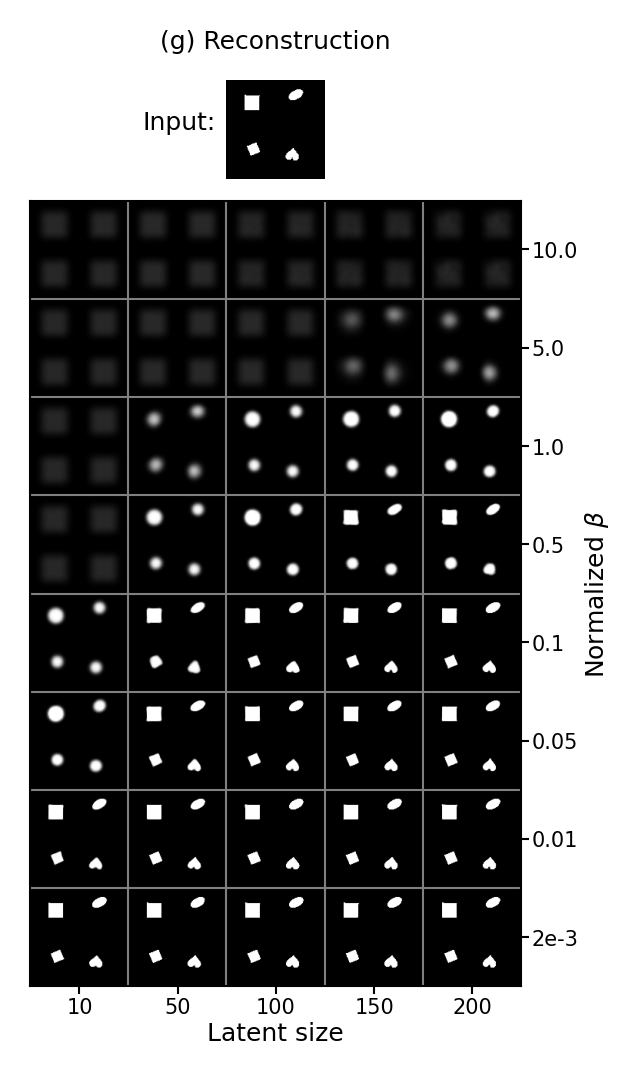

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [1, 8]},
                         dpi=300, facecolor='w', figsize=(6, 4)) 
plt.subplots_adjust(hspace=0.05)

ax = axes[0]
ax.imshow(img_data.T, origin='lower', cmap='binary_r')
ax.axis('off')
ax.text(-110, 64, 'Input:', fontsize=fontsize)
ax.set_title('(g) Reconstruction', fontsize=fontsize, y=1.2)

ax = axes[1]
ax.imshow(img_big.T, origin='lower', cmap='binary_r')
ax.set_xticks(np.arange(N, len(nlats_img) * N - 1, N) - .5, minor=True)
ax.set_yticks(np.arange(N, len(betas_img) * N - 1, N) - .5, minor=True)
ax.grid(which='minor', c='gray', lw=.5)
ax.set_xticks(np.arange(N / 2, len(nlats_img) * N - 1, N))
ax.set_yticks(np.arange(N / 2, len(betas_img) * N - 1, N))
ax.set_xticklabels(nlats_img, fontsize=fontsize-1)
ax.set_xlabel(r'Latent size', fontsize=fontsize)
ax.set_yticklabels(betas_img, fontsize=fontsize-1)
yl = ax.get_yticklabels()
yl[0] = yl[0].__class__(0, 5, '2e-3')
ax.set_yticklabels(yl)
ax.set_ylabel(r'Normalized $\beta$', fontsize=fontsize)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params('both', length=2, pad=0.5, which='major', labelsize=fontsize-1)

plt.savefig('figures/reconstruction.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

# Metric

In [7]:
# read grid
betas = np.loadtxt('grid_betas')
nlats = np.loadtxt('grid_nlats').astype(int)

# read data
LCM = np.load('results/metric_LCM.npy')
MIG = np.load('results/metric_MIG.npy')
MID = np.load('results/metric_MID.npy')
REC = np.load('results/metric_REC.npy')
KL = np.load('results/metric_KL.npy')
LOSS = np.load('results/metric_LOSS.npy')

# normalise
REC /= 4096
LOSS /= 4096
KL /= nlats
ELBO = (REC * 4096 + KL * nlats) / 4096

In [8]:
# VAE region
beta_loc_one = []
for nlat in nlats:
    unnorm_betas = betas / nlat * 4096
    loc = np.argmin(np.abs(unnorm_betas - 1.))
    beta_loc_one.append(loc)
beta_loc_one = beta_loc_one[::-1]

vae_curve = []
for x, y in enumerate(beta_loc_one):
    vae_curve.append([x, y])
    vae_curve.append([x + 1, y])
vae_curve.pop(0)
vae_curve.pop(0)
vae_curve = np.array(vae_curve, dtype=float)
vae_curve[:, 0] += .5
vae_curve[:, 1] -= .5

vae_curve1 = vae_curve.copy()
vae_curve1[:, 0] -= 1
vae_curve1[:, 1] += 1

vae_curve1[0, 0] += 1
vae_curve1[0, 1] -= 1
vae_curve[-1, 0] -= 1
vae_curve[-1, 1] += 1

In [9]:
# under-trained region
rec_loc_large = []
for i, nlat in enumerate(nlats):
    loc = np.argwhere(REC[:, i] < 0.13)[-1][0]
    rec_loc_large.append(loc)
rec_loc_large = rec_loc_large[::-1]

under_curve = []
for x, y in enumerate(rec_loc_large):
    under_curve.append([x, y])
    under_curve.append([x + 1, y])
under_curve.insert(0, [under_curve[0][0], 31])
under_curve.append([under_curve[-1][0], 31])
under_curve.append([0, 31])

under_curve = np.array(under_curve, dtype=float)
under_curve[:, 0] -= .5
under_curve[:, 1] += .5

In [10]:
def plot_metric(fig, ax, data, cm, title, vmin=None, vmax=None, xtick=False, ytick=False, 
                cm_scale=1, vae=False, under_trained=False):
    im = ax.imshow(data[:, ::-1] * cm_scale, origin='lower', 
                   cmap=cm, vmin=vmin*cm_scale, vmax=vmax*cm_scale)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="6%", pad=0.01)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params('both', length=0, pad=0.5, which='major', labelsize=fontsize-1)
    ax.set_xticks(xticks_id)
    ax.set_yticks(yticks_id)
    if xtick:
        ax.set_xticklabels(xticks, fontsize=fontsize-1)
        ax.set_xlabel(r'Latent size', fontsize=fontsize)
    else:
        ax.set_xticklabels([])
    if ytick:
        ax.set_yticklabels(yticks, fontsize=fontsize-1)
        ax.set_ylabel(r'Normalized $\beta$', fontsize=fontsize)
        yl = ax.get_yticklabels()
        yl[0] = yl[0].__class__(0, 5, '2e-3')
        ax.set_yticklabels(yl)
    else:
        ax.set_yticklabels([])
    if cm_scale != 1:
        title += ' (×%d)' % cm_scale
    ax.set_title(title, fontsize=fontsize)
    ax.tick_params('both', length=2, width=0.5, pad=0.5, which='major')
    ax.set_xticks(np.arange(len(nlats) - 1) + .5, minor=True)
    ax.set_yticks(np.arange(len(betas)) + .5, minor=True)
    ax.grid(which='minor', c='gray', lw=.1)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xlim(-.6, 24.6)
    ax.set_ylim(-.6, 31.6)
    ax.plot([-.5, 24.5], [-.5, -.5], c='k', lw=.5)
    ax.plot([24.5, 24.5], [-.5, 31.5], c='k', lw=.5)
    ax.plot([24.5, -0.5], [31.5, 31.5], c='k', lw=.5)
    ax.plot([-.5, -.5], [-.5, 31.5], c='k', lw=.5)
    if vae:
        ax.plot(vae_curve[:, 0], vae_curve[:, 1], c='w', lw=.7, zorder=10000)
        ax.plot(vae_curve1[:, 0], vae_curve1[:, 1], c='w', lw=.7, zorder=10000)
        ax.text(12.5, 9, 'VAE', color='w', ha='center', fontsize=fontsize)
        ax.arrow(12.5, 8.5, 0, -2.5, color='w', lw=0, width=.3, 
                 length_includes_head=True, zorder=10000, )
    if under_trained:
        ax.plot(under_curve[:, 0], under_curve[:, 1], c='magenta', lw=.7, zorder=10000)
        ax.text(1, 30., 'Under-trained', color='magenta', va='top', fontsize=fontsize)

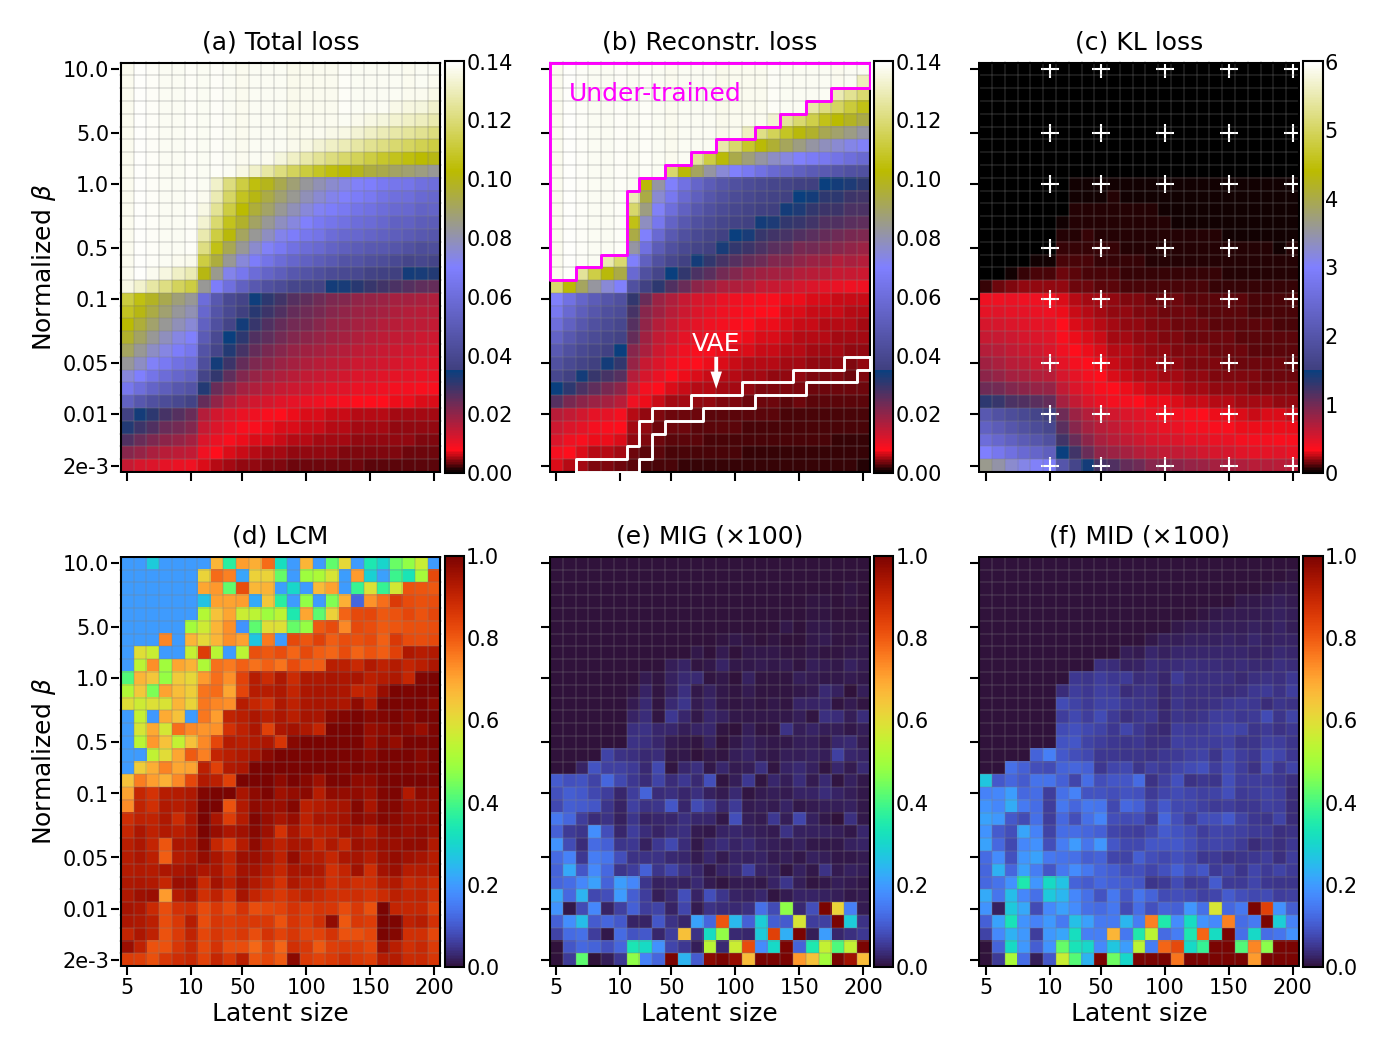

In [11]:
# settings
xticks_id = np.array([0, 5, 9, 14, 19, 24])
yticks_id = [0, 4, 8, 13, 17, 22, 26, 31]
xticks = nlats[::-1][xticks_id]
yticks = betas[yticks_id]
cm_loss = 'gist_stern'
cm_metric = 'turbo'

# metrics
fig, axes = plt.subplots(nrows=2, ncols=3, dpi=300, facecolor='w') 
plt.subplots_adjust(wspace=-.2)
plot_metric(fig, axes[0, 0], LOSS, cm_loss, '(a) Total loss', vmin=0, vmax=.14, 
            xtick=False, ytick=True)
plot_metric(fig, axes[0, 1], REC, cm_loss, '(b) Reconstr. loss', vmin=0, vmax=.14, 
            xtick=False, ytick=False, vae=True, under_trained=True)
plot_metric(fig, axes[0, 2], KL, cm_loss, '(c) KL loss', vmin=0, vmax=6., 
            xtick=False, ytick=False)

plot_metric(fig, axes[1, 0], LCM, cm_metric, '(d) LCM', vmin=0, vmax=1.0, 
            xtick=True, ytick=True)
cm_scale = 100
plot_metric(fig, axes[1, 1], MIG, cm_metric, '(e) MIG', vmin=0, vmax=1/cm_scale, 
            xtick=True, ytick=False, cm_scale=cm_scale)
plot_metric(fig, axes[1, 2], MID, cm_metric, '(f) MID', vmin=0, vmax=1/cm_scale, 
            xtick=True, ytick=False, cm_scale=cm_scale)
xticks_id_rec = [5, 9, 14, 19, 24]
x, y = np.meshgrid(xticks_id_rec, yticks_id)
axes[0, 2].scatter(x, y, c='w', marker='+', s=20, lw=0.5)

plt.savefig('figures/metrics.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

# History

In [12]:
def plot_hist(fname):
    hist = np.load(f'results/{fname}.npy')
    fig, axes = plt.subplots(nrows=len(betas), ncols=len(nlats), dpi=200, facecolor='w')
    for i in range(len(betas)):
        for j in range(len(nlats)):
            axes[i, j].plot(hist[i, j].reshape(-1), c='k', lw=.2)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].axis('off')
    fig.suptitle(fname, y=.92)
    plt.show()

In [13]:
# plot_hist('hist_loss')